Trying all gestational weeks for sample of cohort (10K)
- without interactions
- with confounders
- with true outcome

In [363]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import multiprocessing as mp
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from econml.dml import CausalForestDML
from sklearn.preprocessing import PolynomialFeatures

np.set_printoptions(suppress=True)

In [364]:
births = pd.read_csv("data/birth_w_percentile_confounders.csv")

births = births.dropna(subset=['max_o3_01', 'max_o3_02', 'max_o3_03', 'max_o3_04', 
                                'max_o3_05', 'max_o3_06', 'max_o3_07', 'max_o3_08', 
                                'max_o3_09', 'max_o3_10', 'max_o3_11', 'max_o3_12', 
                                'max_o3_13', 'max_o3_14', 'max_o3_15', 'max_o3_16', 
                                'max_o3_17', 'max_o3_18', 'max_o3_19', 'max_o3_20', 
                                'max_o3_21', 'max_o3_22', 'max_o3_23', 'max_o3_24', 
                                'max_o3_25', 'max_o3_26', 'max_o3_27'])

o3_mean = births[['max_o3_01', 'max_o3_02', 'max_o3_03', 'max_o3_04', 
                  'max_o3_05', 'max_o3_06', 'max_o3_07', 'max_o3_08', 
                  'max_o3_09', 'max_o3_10', 'max_o3_11', 'max_o3_12', 
                  'max_o3_13', 'max_o3_14', 'max_o3_15', 'max_o3_16', 
                  'max_o3_17', 'max_o3_18', 'max_o3_19', 'max_o3_20', 
                  'max_o3_21', 'max_o3_22', 'max_o3_23', 'max_o3_24', 
                  'max_o3_25', 'max_o3_26', 'max_o3_27']].values.mean()
o3_sd = births[['max_o3_01', 'max_o3_02', 'max_o3_03', 'max_o3_04', 
                'max_o3_05', 'max_o3_06', 'max_o3_07', 'max_o3_08', 
                'max_o3_09', 'max_o3_10', 'max_o3_11', 'max_o3_12', 
                'max_o3_13', 'max_o3_14', 'max_o3_15', 'max_o3_16', 
                'max_o3_17', 'max_o3_18', 'max_o3_19', 'max_o3_20', 
                  'max_o3_21', 'max_o3_22', 'max_o3_23', 'max_o3_24', 
                  'max_o3_25', 'max_o3_26', 'max_o3_27']].values.std()

bwp_mean = births["bw_percentile"].mean()
bwp_sd = births["bw_percentile"].std()


/var/folders/75/b6cym0892z93rs6dbfy789240000gn/T/ipykernel_52870/1736032849.py:1: DtypeWarning: Columns (15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  births = pd.read_csv("data/birth_w_percentile_confounders.csv")


In [365]:
births

,gestation,gender,momid,birthdd,birthmm,birthccyy,race,ethn,race_ethn,hypertension_pre,...,max_o3_28,max_o3_40,max_o3_42,max_o3_43,max_o3_44,mean_g,sd_g,X,bw_zscore,bw_percentile
154,27,Female,8.278953e+07,15,1,2014,white,not hispanic,white,0,...,NaN,NaN,NaN,NaN,NaN,934,168,NaN,-0.529762,29.813851
155,27,Female,1.788940e+08,26,3,2015,white,hispanic,hispanic,0,...,NaN,NaN,NaN,NaN,NaN,934,168,NaN,-3.297619,0.048754
156,27,Female,2.152774e+08,18,2,2016,white,not hispanic,white,0,...,NaN,NaN,NaN,NaN,NaN,934,168,NaN,1.166667,87.832750
157,27,Female,2.283783e+08,24,5,2014,white,not hispanic,white,0,...,NaN,NaN,NaN,NaN,NaN,934,168,NaN,9.202381,100.000000
158,27,Female,2.342949e+08,14,2,2014,white,not hispanic,white,0,...,NaN,NaN,NaN,NaN,NaN,934,168,NaN,0.113095,54.502247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44673,41,Male,8.991114e+08,2,10,2016,white,hispanic,hispanic,0,...,81.979019,43.750935,NaN,NaN,NaN,3691,518,NaN,-0.571429,28.385458
44674,41,Male,9.379894e+08,8,6,2016,white,hispanic,hispanic,0,...,42.219223,61.965676,NaN,NaN,NaN,3691,518,NaN,0.277992,60.949086
44675,41,Male,9.517653e+08,22,7,2015,white,hispanic,hispanic,0,...,52.928770,59.577870,NaN,NaN,NaN,3691,518,NaN,-0.938224,17.406467
44676,41,Male,9.657087e+08,1,2,2016,asian,hispanic,hispanic,0,...,37.966217,37.795668,NaN,NaN,NaN,3691,518,NaN,0.152510,56.060751


In [366]:
# confounders

# # note: don't current have definitions; combining based on what's uncommon and ordering scheme
edu_hs = [0, 1, 2, 3]
edu_mid = [4, 5, 6]
edu_higher = [7, 8, 9]

# hand dummy code education, since there are such small groups
births["edu_hs"] = np.where(np.isin(births["momeducation"], edu_hs), 1, 0) # ~ high school or less
births["edu_mid"] = np.where(np.isin(births["momeducation"], edu_mid), 1, 0)
births["edu_higher"] = np.where(np.isin(births["momeducation"], edu_higher), 1, 0) # higher education

# check that race looks correct
births["race_ethn"].value_counts()

# now make dummy variables for race_ethn, medicaid use
births = pd.get_dummies(births, columns=['race_ethn', 'mommedicaid'], drop_first=False, dtype=int)

births = births.reindex(sorted(births.columns), axis=1)

# put in lists to combine
list_temp = births.loc[:, "mean_temp_01":"mean_temp_27"].columns.tolist()
list_no2 = births.loc[:, "mean_no2_01":"mean_no2_27"].columns.tolist()
list_race = births.loc[:, "race_ethn_amindian":"race_ethn_other"].columns.tolist()
# list_edu_0 = births.loc[:, "momeducation_4":"momeducation_5"].columns.tolist() # why don't we need a referent?
list_o3 = births.loc[:, "mean_o3_01":"mean_o3_27"].columns.tolist() # put the W in X?

# mom_age = births.loc[:, "momage"].columns.tolist()

# combine
confounder_cols = list_race + ['edu_hs'] + ['edu_mid'] + ['edu_higher'] + ["momage"] + list_temp + list_no2

# put into X
X = births.loc[:, confounder_cols]


In [367]:
births.columns

Index(['X', 'asthma', 'birthccyy', 'birthdd', 'birthmm', 'birthweightgrams',
       'bw_percentile', 'bw_zscore', 'diabetes_gest', 'diabetes_pre',
       ...
       'race', 'race_ethn_amindian', 'race_ethn_asian', 'race_ethn_black',
       'race_ethn_hispanic', 'race_ethn_nhopi', 'race_ethn_other',
       'race_ethn_white', 'sd_g', 'sourceofpayment'],
      dtype='object', length=393)

In [368]:
list_race

['race_ethn_amindian',
 'race_ethn_asian',
 'race_ethn_black',
 'race_ethn_hispanic',
 'race_ethn_nhopi',
 'race_ethn_other']

In [369]:
## will want to summarize stats from this dataset; but since we're analyzing the full cohort, can just get this information outside the analysis script
# from skimpy import skim
# skim(births.loc[:, confounder_cols])


In [370]:
n_samples = 5000

n_X = 1
n_T = 20
n_W = 1

# treatments / exposures; 10 ppb scale
T_sample = births.sample(n = n_samples, replace = False)

In [371]:


# # how to center?
# o3_mean # is this close to 20? # no, it's ~50

T_01 = ((T_sample['max_o3_01']) - o3_mean) / 10 # / 10 
T_03 = ((T_sample['max_o3_03']) - o3_mean) / 10 # / 10 
T_02 = ((T_sample['max_o3_02']) - o3_mean) / 10 # / 10 
T_04 = ((T_sample['max_o3_04']) - o3_mean) / 10 # / 10 
T_05 = ((T_sample['max_o3_05']) - o3_mean) / 10 # / 10 
T_06 = ((T_sample['max_o3_06']) - o3_mean) / 10 # / 10 
T_07 = ((T_sample['max_o3_07']) - o3_mean) / 10 # / 10 
T_08 = ((T_sample['max_o3_08']) - o3_mean) / 10 # / 10 
T_09 = ((T_sample['max_o3_09']) - o3_mean) / 10 # / 10 
T_10 = ((T_sample['max_o3_10']) - o3_mean) / 10 # / 10 
T_11 = ((T_sample['max_o3_11']) - o3_mean) / 10 # / 10 
T_12 = ((T_sample['max_o3_12']) - o3_mean) / 10 # / 10 
T_13 = ((T_sample['max_o3_13']) - o3_mean) / 10 # / 10 
T_14 = ((T_sample['max_o3_14']) - o3_mean) / 10 # / 10 
T_15 = ((T_sample['max_o3_15']) - o3_mean) / 10 # / 10 
T_16 = ((T_sample['max_o3_16']) - o3_mean) / 10 # / 10 
T_17 = ((T_sample['max_o3_17']) - o3_mean) / 10 # / 10 
T_18 = ((T_sample['max_o3_18']) - o3_mean) / 10 # / 10 
T_19 = ((T_sample['max_o3_19']) - o3_mean) / 10 # / 10 
T_20 = ((T_sample['max_o3_20']) - o3_mean) / 10 # / 10 
T_21 = ((T_sample['max_o3_21']) - o3_mean) / 10 # / 10 
T_22 = ((T_sample['max_o3_22']) - o3_mean) / 10 # / 10 
T_23 = ((T_sample['max_o3_23']) - o3_mean) / 10 # / 10 
T_24 = ((T_sample['max_o3_24']) - o3_mean) / 10 # / 10 
T_25 = ((T_sample['max_o3_25']) - o3_mean) / 10 # / 10 
T_26 = ((T_sample['max_o3_26']) - o3_mean) / 10 # / 10 
T_27 = ((T_sample['max_o3_27']) - o3_mean) / 10 # / 10 

T = pd.DataFrame({'tx_01': T_01, 'tx_02': T_02, 'tx_03': T_03, 'tx_04': T_04,
                    'tx_05': T_05, 'tx_06': T_06, 'tx_07': T_07, 'tx_08': T_08,
                    'tx_09': T_09, 'tx_10': T_10, 'tx_11': T_11, 'tx_12': T_12, #'tx_09:tx_10': T_09*T_10, # no intx
                    'tx_13': T_13, 'tx_14': T_14, 'tx_15': T_15, 'tx_16': T_16,
                    'tx_17': T_17, 'tx_18': T_18, 'tx_19': T_19, 'tx_20': T_20,
                    'tx_21': T_21, 'tx_22': T_22, 'tx_23': T_23, 'tx_24': T_24,
                    'tx_25': T_25, 'tx_26': T_26, 'tx_27': T_27})

# confounders
# W columns
# confounder_cols = list_race + ['edu_hs'] + ['edu_mid'] + ['edu_higher'] + list_temp + list_no2
X = T_sample.loc[:, confounder_cols]

# X columns
# confounder_cols = list_race + ['edu_hs'] + ['edu_mid'] + ['edu_higher']# + list_temp + list_no2
# X = T_sample.loc[:, confounder_cols]

# outcome
y = pd.DataFrame({"y": T_sample["bw_percentile"]})

In [372]:
# # making sure everything is where it should be

# births.loc[41247, "bw_percentile"] # 94.9217828932523
# births.loc[41247, "max_o3_18"] # 54.5505733439188
# births.loc[41247, "mean_no2_19"] # 40.23.4342454428571
# births.loc[41247, "race_ethn"] # white

# T_sample # row 1 (41247) bw_percentile 94.921783, 
# T_sample.loc[41247, "bw_percentile"]
# X.loc[41247, "mean_no2_19"]

In [373]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      min_samples_leaf = 50,
                      min_samples_split = 30,
                      n_estimators = 100, # increase to 2000 on CHPC
                      n_jobs = 4, 
                      # cv = 1, # when just getting cate, CV won't change results
                      criterion = "het")#, # note: might prefer mse
                    #   max_depth = 5)

est.fit(y, T=T, X=X, W=X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklea

Check model fit

In [333]:
import itertools
from itertools import chain

In [338]:
fx_tuple = est.marginal_effect(T, X)

fx_df = pd.DataFrame(list(chain.from_iterable(fx_tuple)))

fx_df.to_csv("data/individual_ates.csv", sep = ',', index = False)


In [245]:
### with only static confounders
params_tune = {
    "criterion": ["mse", "het"], # just use heteogeneity
    # "min_samples_split": [10, 20, 30, 40, 50, 60, 70],
    # "min_samples_leaf": [10, 20, 30, 40, 50, 60, 70],
    # "max_depth": [5, 10, 15]
}
# note: seems like balancedness prefers the default, 0.45

est.tune(y, T, X=X, W=X, params=params_tune)
# returns self, with optimized parameters; needs to be refit

est.criterion # prefers mse with static confounders, as well as dynamic confounders

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklea

'mse'

In [167]:
params_tune = {
    # "criterion": ["mse", "het"], # just use heteogeneity
    "min_samples_split": [10, 20, 30, 40, 50, 60, 70],
    "min_samples_leaf": [10, 20, 30, 40, 50, 60, 70],
    "max_depth": [5, 10, 15]
}
# note: seems like balancedness prefers the default, 0.45

est.tune(y, T, X=X, W=X, params=params_tune)
# returns self, with optimized parameters; needs to be refit

# new hyperparameters
min_leaf = est.min_samples_leaf
min_split = est.min_samples_split
max_dep = est.max_depth

# store, for methods write up
hyperparam_res = pd.DataFrame({
    'min_leaf': min_leaf,
    'min_split': min_split,
    'max_dep': max_dep},
    index=[0])

hyperparam_res.to_csv("hyperparameters.csv", sep = ',', index = False)

# refit
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      min_samples_leaf = min_leaf,
                      min_samples_split = min_split,
                      n_estimators = 100, # increase to 2000 on CHPC
                      n_jobs = 4,
                      criterion = "het",
                      max_depth = max_dep)

est.fit(y, T=T, X=X, W=X)

KeyboardInterrupt: 

In [374]:
res = est.marginal_ate_inference(T, X = X)
means = est.marginal_ate(T, X)
ci_lower, ci_upper = res.conf_int_mean()
treatments = np.array(est.cate_treatment_names())
p_vals = res.pvalue()

res_df = pd.DataFrame({
    # 'sim_index': iteration,
    # 'cw_size': window_size, 'cw_timedep': window_time,
    'treatment': treatments,
    # 'true_effect': cw_window_type,
    'mean': means[0],
    'ci_lower': ci_lower[0],
    'ci_upper': ci_upper[0],
    'p_value': p_vals[0]
})

In [169]:
res_df.to_csv("results_v1.csv", sep = ',', index = False)

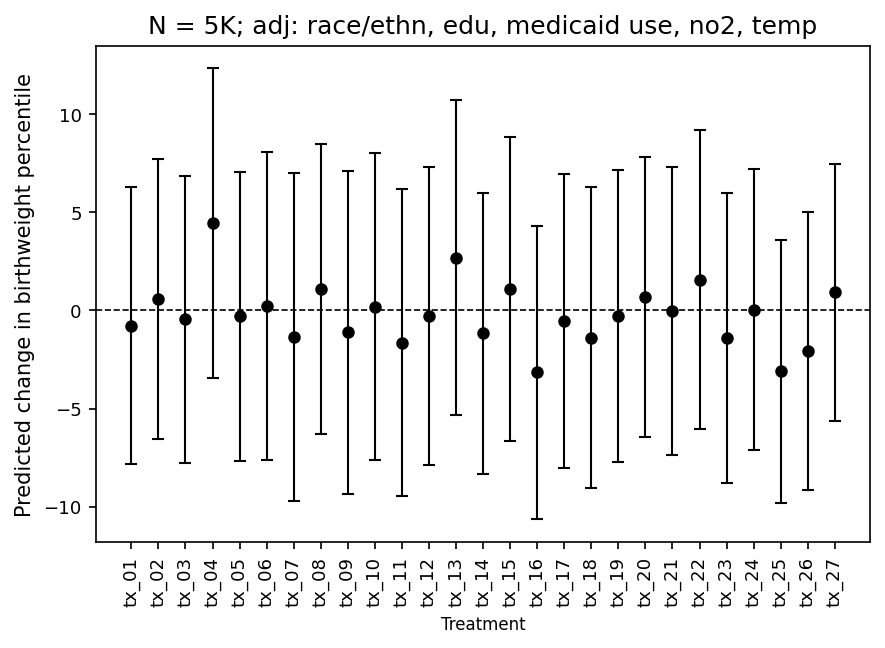

In [375]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['mean'] - res_df['ci_lower'], res_df['ci_upper'] - res_df['mean']])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8.7)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight percentile')
plt.tight_layout()
plt.xticks(rotation=90)
plt.title("N = 5K; adj: race/ethn, edu, medicaid use, no2, temp")
# plt.show()

plt.savefig("fig_effects over time_v1.pdf")
# plt.close()

In [215]:
X.shape

(5000, 9)

In [ ]:
n_panels = 27  # number of panels
n_periods = 3  # number of time periods per panel
n = n_panels * n_periods
groups = np.repeat(a=np.arange(n_panels), repeats=n_periods, axis=0)

In [203]:
n_panels = 100  # number of panels
n_periods = 3  # number of time periods per panel
n = n_panels * n_periods
groups = np.repeat(a=np.arange(n_panels), repeats=n_periods, axis=0)
X = np.random.normal(size=(n, 1))
T = np.random.normal(size=(n, 2))
y = np.random.normal(size=(n, ))

In [202]:
from econml.panel.dml import DynamicDML
est = DynamicDML()
est.fit(y, T, X=X, W=X, groups=groups)

TypeError: DynamicDML.fit() missing 1 required keyword-only argument: 'groups'